markdown testing

In [1]:
from google.colab import drive

#Mount Google Drive
drive.mount('/content/drive')

#Navigate to the project directory
%cd /content/drive/MyDrive/ML_Projects/capstone_project



Mounted at /content/drive
/content/drive/MyDrive/ML_Projects/capstone_project


In [17]:

#  Load the GitHub token from the github_text folder
with open('/content/drive/MyDrive/ML_Projects/github_text/github_token.txt', 'r') as file:
    token = file.read().strip()

# Set the GitHub remote URL with the token and configure Git
!git config --global user.email "george.nchira@gmail.com"
!git config --global user.name "George-Chira"
!git remote set-url origin https://{token}@github.com/George-Chira/capstone_project.git


We begin by loading the data and viewing the dataframe

In [2]:
import pandas as pd

# Load the CSV file
file_path = '/content/drive/MyDrive/ML_Projects/capstone_project/data/FAQ_extracted.csv'
df = pd.read_csv(file_path)

# Display the first few rows to understand the data structure
df.head()


,Question,Answer
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser..."
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...


After loading the data, we need to add a `Category` column based on question ranges. This column will help group questions by themes (A-I), making intent creation easier.


In [3]:
# Define the category assignments based on question ranges
df['Category'] = ''  # Initialize the 'Category' column

# Assign categories based on the question ranges
df.loc[0:3, 'Category'] = 'Understanding Social Health Authority (SHA)'       # Questions 1 - 4
df.loc[4:17, 'Category'] = 'Institutions Created by UHC Laws and Transition'  # Questions 5 - 18
df.loc[18:23, 'Category'] = 'NHIF Staff Considerations During Transition'     # Questions 19 - 24
df.loc[24:30, 'Category'] = 'Primary Health Care & the PHC Fund'              # Questions 25 - 31
df.loc[31:35, 'Category'] = 'Emergency, Chronic, and Critical Illness Fund'   # Questions 32 - 36
df.loc[36:71, 'Category'] = 'Registration, Means Testing & Contributions'     # Questions 37 - 72
df.loc[72:83, 'Category'] = 'Benefits, Tariffs & Claims Management'           # Questions 73 - 84
df.loc[84:90, 'Category'] = 'Access & Quality of Service Provision'           # Questions 85 - 91
df.loc[91:92, 'Category'] = 'Feedback and Dispute Resolution'                 # Questions 92 - 93

# Check the DataFrame to verify the changes
df.head()



,Question,Answer,Category
0,Why was the shift to Universal Health Coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,What is Social Health Insurance (SHI)?,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,What are the Principles of Social Health Insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,Why is Social Health Insurance important?,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,What are the 4 Health Laws?,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


After labeling questions into categories, we clean the `Question` column by converting text to lowercase, removing punctuation, and preserving only four-digit numbers (years) to maintain consistent formatting for intent recognition.


In [12]:
!git add .
!git commit -m "data loading and category definitions"
!git push



[main 2bb6b79] data loading and category definitions
 4 files changed, 26 insertions(+), 26 deletions(-)
 rewrite notebooks/Chira.ipynb (98%)
Enumerating objects: 169, done.
Counting objects: 100% (169/169), done.
Delta compression using up to 2 threads
Compressing objects: 100% (156/156), done.
Writing objects: 100% (166/166), 140.96 MiB | 9.68 MiB/s, done.
Total 166 (delta 69), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (69/69), completed with 1 local object.
To https://github.com/George-Chira/capstone_project.git
   71dfc96..2bb6b79  main -> main


In [4]:
import re

# Convert questions to lowercase
df['Question'] = df['Question'].str.lower()

# Remove all punctuation and special characters, but keep four-digit years
df['Question'] = df['Question'].apply(lambda x: re.sub(r'[^a-zA-Z\s]|\b(?!\d{4}\b)\b\d+\b', '', x))

# Remove duplicates based on the 'Question' column
df.drop_duplicates(subset='Question', inplace=True)

# Check the cleaned data
df.head()


,Question,Answer,Category
0,why was the shift to universal health coverage...,To ensure that all Kenyans have access to qual...,Understanding Social Health Authority (SHA)
1,what is social health insurance shi,It is a form of health financing mechanism bas...,Understanding Social Health Authority (SHA)
2,what are the principles of social health insur...,"Accessible, quality, affordable healthcare ser...",Understanding Social Health Authority (SHA)
3,why is social health insurance important,An efficient way of managing health funds – ab...,Understanding Social Health Authority (SHA)
4,what are the health laws,1. The Social Health Insurance Law (2023) – Cr...,Institutions Created by UHC Laws and Transition


In [14]:
!git add .
!git commit -m "initial data cleaning"


[main dc15b78] initial data cleaning
 1 file changed, 1 insertion(+), 1 deletion(-)


### Intent and Entity Setup

After cleaning the data, we now define intents based on each category and question. This step involves organizing questions into intent groups (e.g., `ask_sha`, `ask_uhc_institutions`) and preparing example questions for each intent. We save these intents in a `nlu.yml` file, which will guide the model in recognizing user queries accurately.


In [5]:


# Define the YAML content
nlu_yml_content = """

nlu:
  - intent: ask_sha
    examples: |
      - why was the shift to universal health coverage necessary
      - what is social health insurance shi
      - what are the principles of social health insurance
      - why is social health insurance important

  - intent: ask_uhc_institutions
    examples: |
      - what are the health laws
      - what informs the proposed reforms towards the shi why was the transition to sha necessary instead of revamping nhif
      - what is the difference between sha and shif
      - what is the transition process from nhif to sha
      - how will the transition process from nhif to sha be done
      - are the three bodies under sha independent with own structures
      - will the current running contracts with suppliers and health care providers be affected by the transition process
      - are nhif assets and liabilities automatically shas
      - how will the transition process ensure continuity of services to kenyans
      - what happens to contributions paid in advance by self-employed persons if the means testing determine their rates to be lower or higher than ksh
      - how will the healthcare contracts be seamlessly transitioned in view of the new benefit package
      - will we remain our regionalbranch network
      - will there be rebranding of the new entities once they come on board
      - what happens to the ict infrastructure

  - intent: ask_nhif_transition
    examples: |
      - how will staff be affected by the transition process
      - what happens to staff who will not be absorbed by the sha
      - in the event that sha remuneration package is lower than that of nhif how will this impact the transitioned staff
      - what becomes of the staff pension contributions for staff who transition to sha and those who are deployed to other public service sectors
      - will the union be fully involved in the transition process
      - will there be forced exits

  - intent: ask_phc_fund
    examples: |
      - what is primary health care
      - what is primary health care fund
      - who is eligible to access the primary healthcare fund
      - how will i register for the primary healthcare fund
      - will i have to contribute to the primary healthcare fund what other sources of funds are there
      - when will i use the primary healthcare fund
      - what is the maximum amount the primary healthcare fund can cover

  - intent: ask_emergency_fund
    examples: |
      - what is the emergency chronic and critical illness fund
      - who will be eligible to register to the emergency chronic and critical illness fund
      - when will i start benefiting from the emergency chronic and critical illness fund
      - how will my benefit package look like in the emergency chronic and critical illness fund
      - which institution will be responsible for management of the emergency chronic and critical illness fund

  - intent: ask_registration
    examples: |
      - who will be eligible to register for sha
      - do i need to register afresh as an sha member if i was already an nhif member
      - will there be any costs associated with registering afresh
      - can individuals choose not to be part of social health insurance
      - will nhif members automatically transition to be sha members what of the payments that were already paid by members
      - how will i register for shi
      - how do i add dependents and are there limits on the number of children
      - does it cover more than one wife
      - if registration is per household does it mean only one spouse contributes
      - what happens to the dependents if a member passes on
      - what happens to the current biometric that are captured
      - who will be the contributors to social health authority
      - how will i contribute to sha
      - how much will i contribute to sha
      - what happens when the two heads of a household have separate incomes
      - if both spouses are employed are both required to make monthly contributions
      - who is required to pay the minimum contribution of kes per month
      - is there an option for capping the deductions
      - how will the determination of income for the informal sector be done
      - should members wait until means testing is conducted to make contributions
      - if someone transitions or there is a change of income who is responsible for determining the contribution what is the reporting mechanism
      - are kenyans contributing to all three funds and how do these contributions work
      - how many times will i contribute to shi
      - will services be accessible if i lose employment formal vs informal
      - is insurance premium financing available for those who cannot afford consistent payments
      - can cooperative societies join sha as groups and make base minimum contributions
      - what if i am unable to paycontribute to shi
      - which facilities will be contracted and empaneled by sha
      - how will i know which facilities or providers around a given area of residence will be covered by sha
      - what happens to my current contributions to nhif
      - can i choose my healthcare providers and facilities under sha
      - how will sha benefit lowincome and vulnerable populations and plwd
      - are there penalties for defaulters andor late payment
      - how do i pay penalties
      - can i get refunded if i do not utilize my contribution
      - can i take a private health insurance cover

  - intent: ask_benefits_claims
    examples: |
      - for civil servants including hcws what will happen to their enhanced scheme
      - are civil servants cushioned to seek services from private facilities
      - what will happen to the school children who were covered under edu afya
      - what is the package for those who opt to retireexit public service
      - will sha cover travel health insurance
      - when will i use my social health insurance fund
      - how will my benefit package look like in sha
      - how do the sha benefits compare with the nhif benefits
      - how can additional services be added to the essential benefits package
      - what happens to retired civil servants under sha
      - how does the essential benefits package impact premiums
      - how does one get to know what tariffs are in use

  - intent: ask_service_quality
    examples: |
      - which facilities will one access the sha services where do i access services
      - is there a waiting period to access services
      - can one receive phc services in referral hospitals
      - what happens when one falls sick when far from the selected facility
      - there is a need for measures to enhance the quality of care including the role of counties in preventive services
      - where should providers claim payment of pending bills
      - what will be the role of sha in ensuring commodities are available in healthcare facilities

  - intent: ask_feedback_resolution
    examples: |
      - how can individuals in kenya file complaints or seek assistance under social health authority
      - which takes precedence between procurement tribunal and sha tribunal in procurement disputes when contracting and empanelment

  - intent: bot_challenge
    examples: |
      - Are you a real person?
      - Are you a chatbot?
      - Can you prove you're not a bot?

  - intent: goodbye
    examples: |
      - Goodbye
      - See you later
      - Bye

  - intent: iamabot
    examples: |
      - Are you a bot?
      - Are you human or a robot?
      - Are you an AI?

"""

# Path to save in Google Drive
output_path = '/content/drive/MyDrive/ML_Projects/capstone_project//chira/nlu.yml'

# Save to file
with open(output_path, 'w') as file:
    file.write(nlu_yml_content)

print("nlu.yml file created successfully at:", output_path)


nlu.yml file created successfully at: /content/drive/MyDrive/ML_Projects/capstone_project//chira/nlu.yml


# Creating `domain.yml` for Rasa Chatbot

After defining `nlu.yml` with intents and questions, we proceed to create `domain.yml`, which configures the chatbot’s responses and intents

The `domain.yml` file helps Rasa:
- Recognize **intents** and map them to responses.
- Store **responses** for each intent.

    



In [6]:


domain_yml_content = """
intents:
  - ask_sha
  - ask_uhc_institutions
  - ask_nhif_transition
  - ask_phc_fund
  - ask_emergency_fund
  - ask_registration
  - ask_benefits_claims
  - ask_service_quality
  - ask_feedback_resolution
  - bot_challenge
  - goodbye
  - iamabot

responses:
  utter_ask_sha:
    - text: "To ensure that all Kenyans have access to quality, affordable, and comprehensive health services, from health promotion to palliative care without financial hardship."
    - text: "It is a health financing mechanism based on risk and resource pooling to ensure affordable healthcare at the point of need."
    - text: "Accessible, quality, affordable healthcare services for all; well-defined benefit package anchored in law; mandatory registration and contribution; equity."
    - text: "Efficient and equitable management of health funds, with targeted funds for specific priorities or areas."

  utter_ask_uhc_institutions:
    - text: "1. The Social Health Insurance Law (2023) – Establishes SHA.\n2. The Digital Health Act (2023) – Integrates health systems with citizen data for healthcare access.\n3. Facility Improvement Financing Law (2023) – Secures financing for public health facilities.\n4. Primary Care Networks Law (2023) – Legislates collaborative healthcare networks."
    - text: "The goal of SHI is equitable access, consolidation of funds, and reducing financial burden from catastrophic illnesses."
    - text: "SHA oversees three funds: PHCF, SHIF, and ECCF, each with specific mandates and fund sources."
    - text: "SHA will transition NHIF roles under the 2023 Act by November 22, 2023."
    - text: "Transition is managed by the committee formed in 2024, in consultation with health boards."
    - text: "There will be one SHA managing three funds: Primary Care, Social Health, and Emergency Chronic and Critical Illness."
    - text: "SHA assumes NHIF’s contracts and obligations to ensure service continuity."
    - text: "Yes, Section 2(1) of the transition provisions allows automatic transfer of NHIF assets and liabilities."
    - text: "Paid-up members' contracts with NHIF will remain until June 30, 2024."
    - text: "Any premium differences in pre-paid contributions will be adjusted or rolled over."
    - text: "SHA contracts with empaneled providers will be issued under the 2023 SHI Law."
    - text: "Regional branch networks will be determined based on SHA requirements."
    - text: "Rebranding will be determined by each SHA entity."
    - text: "SHA will take ownership of ICT infrastructure as necessary; retired systems will be managed per procurement laws."

  utter_ask_nhif_transition:
    - text: "SHA will recruit staff under its approved organization structure, giving NHIF staff priority."
    - text: "Employees not absorbed by SHA will have options for redeployment or voluntary retirement."
    - text: "Employee salaries at SHA will follow new statutory guidelines, affecting only new hires."
    - text: "Pension contributions for NHIF staff will continue under RBA guidelines during transition."
    - text: "Unions will actively participate in the transition process alongside SHA boards."
    - text: "There is no provision for forced retirements under the SHI Act."

  utter_ask_phc_fund:
    - text: "Primary healthcare is universally accessible, practical care for all community members."
    - text: "The PHC Fund will purchase primary healthcare services."
    - text: "All residents of Kenya are eligible for the PHC Fund."
    - text: "Registration for SHA includes automatic registration for PHC."
    - text: "No individual contributions are required for PHC; it is government-funded."
    - text: "PHC services will be provided free at level 2 and 3 facilities and through referrals."
    - text: "PHC Fund expenditure is based on annual budget estimates set by the SHA."

  utter_ask_emergency_fund:
    - text: "The Emergency Chronic and Critical Illness Fund provides coverage for emergencies and critical illnesses."
    - text: "Eligibility for the Emergency Fund will be based on specific criteria determined by SHA."
    - text: "Benefits will commence as soon as registration is complete and approved."

  utter_ask_registration:
    - text: "All Kenyans and long-term residents are eligible and required to register."
    - text: "NHIF members must re-register with SHA."
    - text: "There are no costs for re-registering with SHA."
    - text: "Social Health Insurance registration is mandatory."
    - text: "The transition committee will ensure smooth transfer of NHIF contributions to SHA."
    - text: "Registration involves completing an SHA form with an ID or approved identification."
    - text: "Dependents can be added without a limit on the number of children."
    - text: "More than one spouse can be registered as dependents if income is captured."
    - text: "Household contribution decisions depend on household income type."
    - text: "Death notification is required to update SHA on dependents or contributor status."
    - text: "New biometric data will be collected during SHA registration."
    - text: "Every household, resident, government entity, employer, and donor can contribute to SHA."
    - text: "Salaried households will contribute monthly, while informal sector households contribute annually."
    - text: "The contribution rate is set at 2.75% of household income."
    - text: "Combined household income is used to calculate contributions."
    - text: "Both spouses are required to make contributions if employed."
    - text: "Those qualifying for Ksh 300 contributions will have the option for subsidies."
    - text: "SHA deductions have no contribution cap."
    - text: "Means Testing will determine income for informal sector members."
    - text: "Salaried contributions are direct, while informal contributions are post means testing."
    - text: "SHA contributions are calculated based on income updates provided to the authority."
    - text: "Government funding supports PHC and ECCF, with direct contributions only for SHI."
    - text: "Salaried households contribute monthly, informal sector households annually."
    - text: "Employment loss does not affect service access as long as the authority is notified."
    - text: "Insurance premium financing is available for non-salaried members."
    - text: "Cooperative societies can make group contributions to SHA."
    - text: "Government subsidies are available for low-income households."
    - text: "SHA will accredit contracted facilities and providers."
    - text: "The authority will publish contracted facilities on its website."
    - text: "NHIF contributions will automatically transfer to SHA."
    - text: "SHA allows choice of healthcare providers."
    - text: "SHA provides additional support to low-income and vulnerable populations."
    - text: "Late payments incur a penalty of 2% of the due contribution."
    - text: "Penalty payment methods will be provided by SHA."
    - text: "No refunds are provided for unused contributions."
    - text: "SHA members may also hold private insurance."

  utter_ask_benefits_claims:
    - text: "For civil servants including HCWs, the enhanced scheme will continue."
    - text: "Civil servants will be able to seek services from private facilities as needed."
    - text: "School children covered under Edu Afya will remain covered as they transition to SHA."
    - text: "Retirees will have a package under SHA that includes healthcare services."
    - text: "SHA will not cover travel health insurance unless explicitly stated."
    - text: "Use of SHA benefits is available as soon as registration is complete."
    - text: "SHA benefits include expanded services over NHIF’s, covering critical illness and emergencies."
    - text: "Additional services can be added to the essential benefits package by request."
    - text: "Retired civil servants have a specific package under SHA with defined benefits."
    - text: "The essential benefits package can impact premium calculations."
    - text: "All tariff information will be made publicly available by SHA."

  utter_ask_service_quality:
    - text: "You can access SHA services at all contracted facilities."
    - text: "Service access will be available immediately, with no waiting period."
    - text: "PHC services will be accessible in all levels of referral hospitals."
    - text: "SHA will cover emergency care at any certified facility, regardless of your selected provider."
    - text: "Counties will play a role in improving preventive services and quality of care."
    - text: "Providers can claim pending bills through the SHA’s official portal."
    - text: "SHA will ensure all essential commodities are available in healthcare facilities."

  utter_ask_feedback_resolution:
    - text: "SHA will implement a complaint resolution mechanism under state corporation governance guidelines."
    - text: "The Public Procurement Tribunal has precedence in procurement disputes under the SHA framework."

  utter_goodbye:
    - text: "Goodbye! If you have any more questions, feel free to ask."

  utter_bot_challenge:
    - text: "I'm here to assist with your questions on social health insurance. Let me know how I can help!"

  utter_iamabot:
    - text: "I am a virtual assistant here to answer your questions on social health coverage."

"""

# Save to a file
output_path = '/content/drive/MyDrive/ML_Projects/capstone_project//chira/domain.yml'
with open(output_path, 'w') as file:
    file.write(domain_yml_content)

output_path


'/content/drive/MyDrive/ML_Projects/capstone_project//chira/domain.yml'

In [18]:
!git add .
!git commit -m "updated domain.yml"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

No commands done.
Next commands to do (8 remaining commands):
   pick 378a895 repository setup
   pick 7af909b repository setup
  (use "git rebase --edit-todo" to view and edit)
You are currently editing a commit while rebasing branch 'main' on '6b7e378'.
  (use "git commit --amend" to amend the current commit)
  (use "git rebase --continue" once you are satisfied with your changes)

nothing to commit, working tree clean


# Creating stories.yml

Here, we create the `stories.yml` file, which defines the flow of conversations for the chatbot. it  Maps out sequences of intents and responses, enabling the bot to manage conversational paths. This structure allows the chatbot to handle multi-step conversations and deliver responses based on the user’s context.


In [7]:
# Define the simplified stories content for Rasa in YAML format
simplified_stories_yml_content = """stories:
  - story: Understanding Social Health Authority (SHA)
    steps:
      - intent: ask_sha
      - action: utter_ask_sha

  - story: Institutions Created by UHC Laws and Transition
    steps:
      - intent: ask_uhc_institutions
      - action: utter_ask_uhc_institutions

  - story: Staff Transition under SHA Inquiry
    steps:
      - intent: ask_nhif_transition
      - action: utter_ask_nhif_transition

  - story: Understanding Primary Health Care Fund Inquiry
    steps:
      - intent: ask_phc_fund
      - action: utter_ask_phc_fund

  - story: Emergency Fund and Critical Illness Inquiry
    steps:
      - intent: ask_emergency_fund
      - action: utter_ask_emergency_fund

  - story: SHA Registration and Contributions Inquiry
    steps:
      - intent: ask_registration
      - action: utter_ask_registration

  - story: Benefits and Claims under SHA Inquiry
    steps:
      - intent: ask_benefits_claims
      - action: utter_ask_benefits_claims

  - story: Service Quality and Access Inquiry
    steps:
      - intent: ask_service_quality
      - action: utter_ask_service_quality

  - story: Feedback and Resolution Mechanism Inquiry
    steps:
      - intent: ask_feedback_resolution
      - action: utter_ask_feedback_resolution

  - story: Bot Challenge Story
    steps:
      - intent: bot_challenge
      - action: utter_bot_challenge
"""

# save the stories file in Google Drive
output_path = '/content/drive/MyDrive/ML_Projects/capstone_project/chira/simplified_stories.yml'

# Write the content to the specified file path
with open(output_path, 'w') as file:
    file.write(simplified_stories_yml_content)

print(f"simplified_stories.yml file has been saved at: {output_path}")


simplified_stories.yml file has been saved at: /content/drive/MyDrive/ML_Projects/capstone_project/chira/simplified_stories.yml


In [20]:
!git add .
!git commit -m "updated stories.yml"

On branch main
Your branch is ahead of 'origin/main' by 1 commit.
  (use "git push" to publish your local commits)

No commands done.
Next commands to do (8 remaining commands):
   pick 378a895 repository setup
   pick 7af909b repository setup
  (use "git rebase --edit-todo" to view and edit)
You are currently editing a commit while rebasing branch 'main' on '6b7e378'.
  (use "git commit --amend" to amend the current commit)
  (use "git rebase --continue" once you are satisfied with your changes)

nothing to commit, working tree clean


In [1]:
!pip install rasa


In [2]:
# Define the project path
project_path = "/content/drive/MyDrive/ML_Projects/capstone_project/chira/rasa_project_files"

# Create the folder
!mkdir -p "$project_path"

# Set the working directory to the new folder
%cd "$project_path"

# Initialize Rasa in this folder
!rasa init --no-prompt

# Verify all files are in the correct location
!ls "$project_path"




/content/drive/MyDrive/ML_Projects/capstone_project/chira/rasa_project_files
/usr/local/lib/python3.10/dist-packages/rasa/core/tracker_store.py:1044: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base: DeclarativeMeta = declarative_base()
(0lqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqk(B
(0x(B Rasa Open Source reports anonymous usage telemetry to help improve the product (0x(B
(0x(B for all its users.                                                             (0x(B
(0x(B                                                            

In [3]:
!rasa train


/usr/local/lib/python3.10/dist-packages/rasa/core/tracker_store.py:1044: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base: DeclarativeMeta = declarative_base()
/usr/local/lib/python3.10/dist-packages/rasa/shared/utils/validation.py:134: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as spe

In [25]:
!git add .
!git commit -m "model training"

[main 6219316] model training
 13 files changed, 118 insertions(+), 145 deletions(-)
 create mode 100644 chira/.rasa/cache/tmpc5xymy90/featurizer.json
 create mode 100644 chira/.rasa/cache/tmpc5xymy90/rule_only_data.json
 create mode 100644 chira/.rasa/cache/tmpc5xymy90/rule_policy.json
 create mode 100644 chira/.rasa/cache/tmpkgwknmnn/featurizer.json
 create mode 100644 chira/.rasa/cache/tmpkgwknmnn/memorized_turns.json
 rewrite chira/domain.yml (99%)
 create mode 100644 chira/models/20241101-070120-amiable-bow.tar.gz


In [6]:
!rasa test nlu --out "/content/drive/MyDrive/ML_Projects/capstone_project/chira/rasa_project_files/results"


/usr/local/lib/python3.10/dist-packages/rasa/core/tracker_store.py:1044: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base: DeclarativeMeta = declarative_base()
/usr/local/lib/python3.10/dist-packages/rasa/shared/utils/validation.py:134: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as spe

In [10]:
import json
import pandas as pd

# Define the path to the results folder
results_path = "/content/drive/MyDrive/ML_Projects/capstone_project/chira/rasa_project_files/results"

# Load and display intent classification metrics
with open(f"{results_path}/intent_report.json", "r") as f:
    intent_report = json.load(f)

# Convert to DataFrame for readability
intent_df = pd.DataFrame(intent_report).T  # Transpose for readability
intent_df.index.name = 'Intent'
print("Intent Classification Metrics:")
display(intent_df)


Intent Classification Metrics:


,precision,recall,f1-score,support,confused_with
Intent,,,,,
deny,1.0,1.0,1.0,7,{}
bot_challenge,1.0,1.0,1.0,4,{}
affirm,1.0,1.0,1.0,6,{}
greet,1.0,1.0,1.0,13,{}
goodbye,1.0,1.0,1.0,10,{}
mood_great,1.0,1.0,1.0,14,{}
mood_unhappy,1.0,1.0,1.0,14,{}
accuracy,1.0,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,68.0,NaN


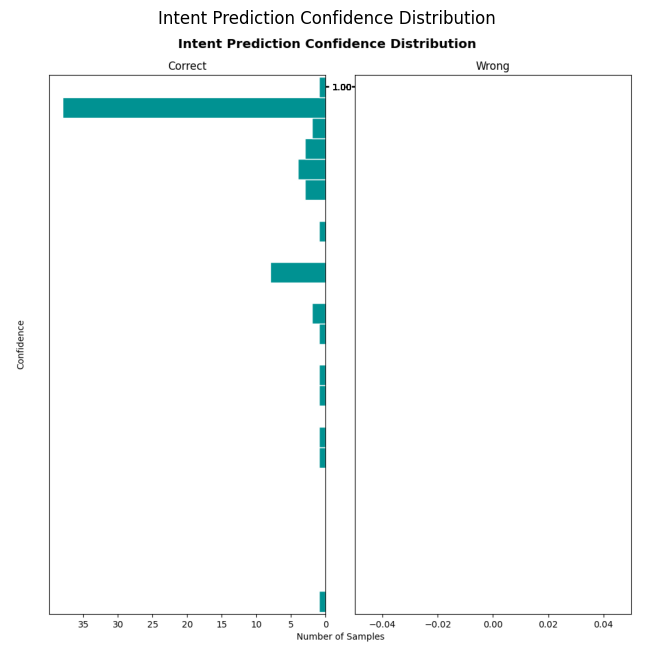

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to images in your Google Drive results folder
histogram_path = "/content/drive/MyDrive/ML_Projects/capstone_project/chira/rasa_project_files/results/intent_histogram.png"

# Display Intent Prediction Confidence Histogram
img_hist = mpimg.imread(histogram_path)
plt.figure(figsize=(10, 8))
plt.imshow(img_hist)
plt.axis('off')  # Hide axes for better visualization
plt.title("Intent Prediction Confidence Distribution")
plt.show()


In [14]:
!rasa x


/usr/local/lib/python3.10/dist-packages/rasa/core/tracker_store.py:1044: MovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base: DeclarativeMeta = declarative_base()
/usr/local/lib/python3.10/dist-packages/rasa/shared/utils/validation.py:134: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as spe

In [19]:
!git add .
!git commit -m "model testing"

On branch main
Your branch is ahead of 'origin/main' by 3 commits.
  (use "git push" to publish your local commits)

No commands done.
Next commands to do (8 remaining commands):
   pick 378a895 repository setup
   pick 7af909b repository setup
  (use "git rebase --edit-todo" to view and edit)
You are currently editing a commit while rebasing branch 'main' on '6b7e378'.
  (use "git commit --amend" to amend the current commit)
  (use "git rebase --continue" once you are satisfied with your changes)

Changes not staged for commit:
  (use "git add/rm <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	deleted:    ../.rasa/cache/cache.db
	deleted:    ../.rasa/cache/tmp0k650j2l/featurizer.json
	deleted:    ../.rasa/cache/tmp0k650j2l/memorized_turns.json
	deleted:    ../.rasa/cache/tmp0n9wbj0_/patterns.pkl
	deleted:    ../.rasa/cache/tmp2_zv4g2v/featurizer.json
	deleted:    ../.rasa/cache/tmp2_zv4g2v/rule_only_data.json
	delet

In [31]:
# Install pyngrok and authenticate with your authtoken
!pip install pyngrok
!ngrok config add-authtoken 2oL9i22pLcJqhGyjqIiZFgGmxQR_3FajGsj7bmRQzmMiPpGgh




Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [32]:
# Start ngrok to create a public URL for the Rasa server
from pyngrok import ngrok
public_url = ngrok.connect(5005)  # Port 5005 is the default port for Rasa
print("Public URL:", public_url)



Public URL: NgrokTunnel: "https://0a05-34-173-109-107.ngrok-free.app" -> "http://localhost:5005"


In [33]:
# Start Rasa server with nohup to keep it running in the background
!nohup rasa run --enable-api --cors "*" &


nohup: appending output to 'nohup.out'


In [ ]:
!tail -f nohup.out


  File "/usr/local/lib/python3.10/dist-packages/aiohttp/client.py", line 1197, in __aenter__
    self._resp = await self._coro
  File "/usr/local/lib/python3.10/dist-packages/aiohttp/client.py", line 479, in _request
    handle = tm.start()
  File "/usr/local/lib/python3.10/dist-packages/aiohttp/helpers.py", line 660, in start
    return self._loop.call_at(when, self.__call__)
  File "uvloop/loop.pyx", line 1339, in uvloop.loop.Loop.call_at
  File "uvloop/loop.pyx", line 1315, in uvloop.loop.Loop.call_later
  File "uvloop/loop.pyx", line 705, in uvloop.loop.Loop._check_closed
RuntimeError: Event loop is closed


In [28]:
!git add .
!git commit -m "chat test"
!git push

[main a29d727] chat test
 1 file changed, 6 insertions(+)
To https://github.com/George-Chira/capstone_project.git
 ! [rejected]        main -> main (fetch first)
error: failed to push some refs to 'https://github.com/George-Chira/capstone_project.git'
hint: Updates were rejected because the remote contains work that you do
hint: not have locally. This is usually caused by another repository pushing
hint: to the same ref. You may want to first integrate the remote changes
hint: (e.g., 'git pull ...') before pushing again.
hint: See the 'Note about fast-forwards' in 'git push --help' for details.


In [29]:
!git pull

remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 26 (delta 9), reused 22 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (26/26), 7.07 KiB | 20.00 KiB/s, done.
From https://github.com/George-Chira/capstone_project
   2bb6b79..3faddc0  main       -> origin/main
hint: You have divergent branches and need to specify how to reconcile them.
hint: You can do so by running one of the following commands sometime before
hint: your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
fatal: Need